<a href="https://colab.research.google.com/github/ChuLinh02/GraphMining/blob/main/HW04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSC17103 - Colab 4 - Phân hoạch và phát hiện cộng đồng trên đồ thị**

Đây là Bài tập 04 trong môn học Khai thác Dữ liệu Đồ thị (Graph Mining) - CSC1703 tại Khoa Công nghệ Thông tin, Trường Đại học Khoa học Tự nhiên, Đại học Quốc gia TP.HCM

(Cập nhật lần cuối: 21/07/2024)

Họ tên: Chu Hải Linh

MSSV: 21120496

## **Cách thực hiện và nộp bài tập**

&#9889; Chú ý, bạn nên thực hiện theo sự hướng dẫn dưới đây. Nếu có bất kỳ điều gì không rõ, bạn cần liên hệ ngay trợ giảng/ giáo viên thực hành để được hỗ trợ kịp thời.

**Cách làm bài**

Bạn sẽ làm trực tiếp trên file notebook này. Đầu tiên, bạn điền họ tên và MSSV vào phần đầu file ở bên trên. Trong file, bạn làm bài ở những chỗ có ghi là:
```python
# YOUR CODE HERE
raise NotImplementedError()
```
hoặc đối với những phần code không bắt buộc thì là:
```python
# YOUR CODE HERE (OPTION)
```
hoặc đối với markdown cell thì là:
```markdown
YOUR ANSWER HERE
```

**Cách nộp bài**

Trước khi nộp bài, bạn chọn `Kernel` - `Restart Kernel & Run All Cells` đối với trường hợp sử dụng môi trường local hoặc `Runtime` - `Restart session and run all` đối với môi trường Google Colab, để đảm bảo mọi chuyện diễn ra đúng như mong đợi.

Sau đó, bạn tạo thư mục nộp bài theo cấu trúc sau:
- Thư mục `MSSV` (ví dụ, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`)
    - File `HW04.ipynb` (không cần nộp các file khác)

Cuối cùng, bạn nén thư mục `MSSV` này lại với định dạng nén là .zip (chứ không được là .rar hay các định dạng khác) và nộp ở link trên moodle. \
<font color=red>Bạn lưu ý tuân thủ chính xác qui định nộp bài này.</font>

## Setup và Import các thứ

In [1]:
# Upgrade packages
!pip install --upgrade scipy networkx

In [2]:
# Import
import numpy as np # For numerical computation
import networkx as nx # For network/ graph manipulation
import matplotlib.pyplot as plt # For visualization
import scipy.stats as st
from scipy.stats import ks_2samp
from zlib import adler32

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import pandas as pd
import seaborn as sns

from IPython.display import clear_output

from collections import Counter
import random

plt.style.use("fast")

from typing import List, Tuple, Dict

%matplotlib inline

In [3]:
# Make sure something
assert nx.__version__ > '2.5'

## Thu thập dữ liệu

Trong bài tập này, chúng ta xem xét dữ liệu đồ thị Les Miserables.

In [4]:
G = nx.Graph()
G.add_edges_from(nx.les_miserables_graph().edges)
pos = nx.kamada_kawai_layout(G)

Trực quan hóa

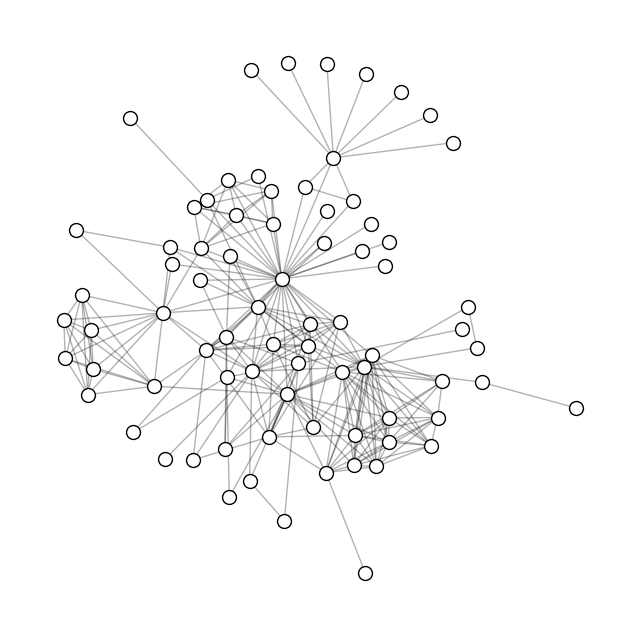

In [5]:
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

## Khám phá dữ liệu

Một số thông tin thống kê cơ bản.

In [6]:
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

Number of nodes 77
Number of edges 254
Average degree 6.597402597402597


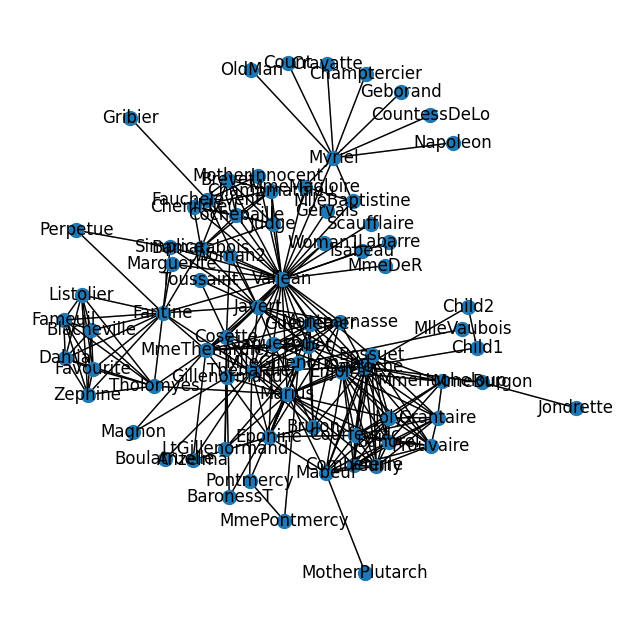

In [7]:
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, pos, with_labels=True, node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

## Task 1. Phân rã $k$-lõi


Trong phần này, chúng ta sẽ áp dụng phân rã $k$-core ($k$-core decomposition) cho mạng lưới này. Bạn sử dụng `nx.core_number` và tô màu mọi đỉnh bằng $k$-shell của nó.

Để hoàn này task này, bạn viết hàm `kcoreDecomposition` mà nhận đầu vào là một đồ thị `G` và trả về một mảng np.array với $k$ phần tử $k$-shell của đỉnh. Ví dụ, nếu ta có các đỉnh 1, 2, 3, 4 và đỉnh 1 nằm trong 1-shell, các đỉnh 2, 3, 4 thì nằm trong 2-shell thì đầu ra sẽ là [1, 2, 2, 2].


In [8]:
def kcoreDecomposition(G: nx.Graph) -> np.ndarray:
    # YOUR CODE HERE
    # Calculate the core number of each node
    core_numbers = nx.core_number(G)
    k_shell = np.array([core_numbers[node] for node in G.nodes])
    return k_shell

In [9]:
# Test
labels = kcoreDecomposition(G)
assert isinstance(labels, np.ndarray), "Output should be a numpy array"
assert labels.shape == (77,), "Output should be an array of shape (77,)"
assert labels.min() == 1, "Minimum core number should be 1"
assert labels.max() == 9, "Maximum core number should be 9"
assert labels[10] == 8
assert labels[65] == 9

expected_values = {
    10: 8,
    20: 8,
    30: 6,
    40: 8,
    50: 7,
    60: 2,
    65: 9
}
for index, value in expected_values.items():
    assert labels[index] == value, f"Core number at index {index} should be {value}"

unique, counts = np.unique(labels, return_counts=True)
counts_dict = dict(zip(unique, counts))

expected_counts = {
    1: 18,
    2: 11,
    3: 7,
    4: 3,
    6: 7,
    7: 11,
    8: 8,
    9: 12
}

for core_num, count in expected_counts.items():
    assert counts_dict[core_num] == count, f"Core number {core_num} should appear {count} times"

Trực quan hóa

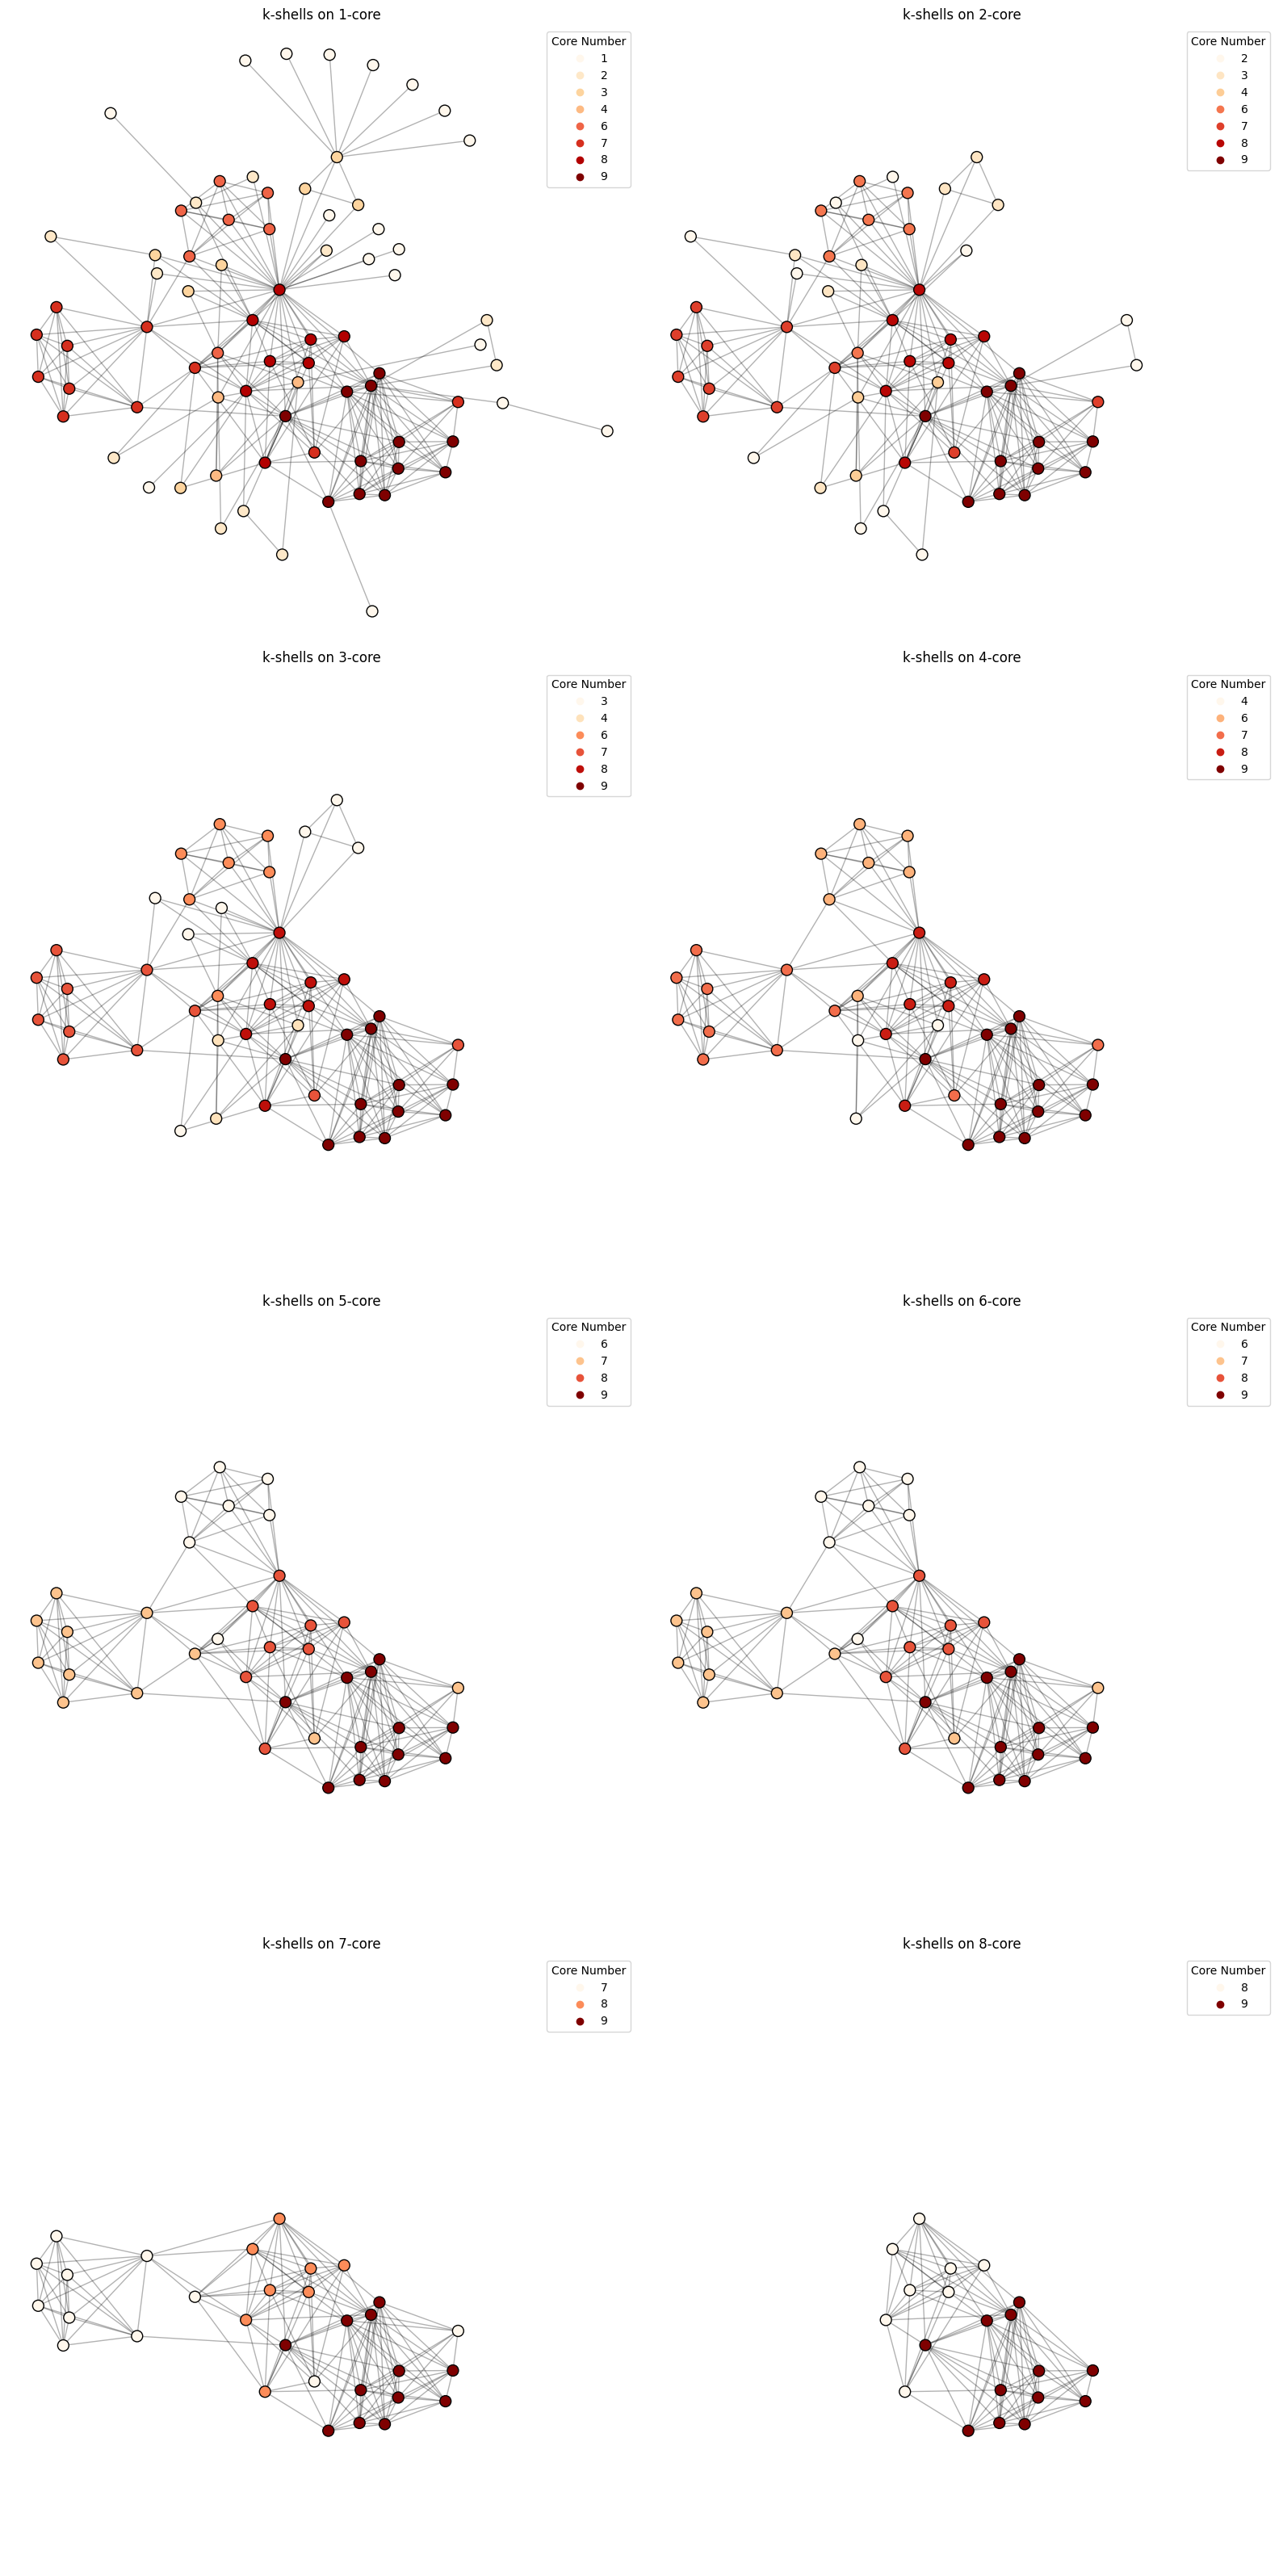

In [10]:
plt.figure(figsize=(16, 32))

positions = np.array(list(pos.values()))
x_min, y_min = positions.min(axis=0)
x_max, y_max = positions.max(axis=0)

for i in range(8):
    plt.subplot(4, 2, i + 1)
    subG = nx.k_core(G, i + 1)

    if len(subG) == 0:
        continue

    core_numbers = kcoreDecomposition(subG)

    nodes = nx.draw_networkx_nodes(
        subG,
        pos,
        cmap=plt.cm.OrRd,
        node_color=core_numbers,
        node_size=100,
        edgecolors='black'
    )

    nx.draw_networkx_edges(
        subG,
        pos,
        alpha=0.3,
        width=1,
        edge_color='black'
    )

    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min - eps, x_max + eps)
    plt.ylim(y_min - eps, y_max + eps)

    plt.legend(*nodes.legend_elements(), title="Core Number")
    plt.axis('off')

    plt.title(f'k-shells on {i + 1}-core')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE

## Task 2. Phát hiện đồ thị con hoàn chỉnh (Clique detection)


Đồ thị con hoàn chỉnh (complete subgraph) hay Clique, một mô hình đơn giản của một cộng đồng. Trong phần này, chúng ta sẽ thực hiện việc tìm kiếm những clique lớn nhất trong một đồ thị bằng sự hỗ trợ của `nx.find_cliques` và trực quan hóa chúng.

Để hoàn thành phần này, bạn cần hoàn thành hàm `largestCliques` mà nhận đầu vào là một đồ thị và nó thực hiện việc tìm kiếm các cliques lớn nhất với cùng kích thước. Việc lựa chọn màu sắc và chiều rộng (width) được thực hiện bởi luật như sau:
- Tất cả các đỉnh có màu `trắng` ngoại trừ đỉnh nằm trong clique lớn nhất.
- Tất cả các cạnh có độ rộng thon gọn (`thin`), rộng thon gọn bao nhiêu là tùy vào việc bạn chọn (tôi không quan tâm), ngoại trừ các cạnh nằm trong cliques thì nó phải dày hơn một chút.

Hàm này trả về một tuple với 2 mảng np.array như sau:
- Mảng `rgb` np.array có shape `[n,m,3]` trong đó `n` là số lượng cliques, `m` là số lượng đỉnh, `3(r, g, b)` là số lượng các giá trị nằm trong khoảng `[0, 1]` thể hiện cho bộ ba màu cơ bản `red`, `green`, và `blue`.
- Mảng `width` np.array có shape `[n,k]` trong đó `n` là số lượng cliques, `k` là số lượng cạnh.

Lưu ý: màu sắc được gán thứ tự bởi `G.nodes`, còn độ rộng được gán thứ tự bởi `G.edges`.

In [11]:
def largestCliques(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
  # YOUR CODE HERE
  # Find all cliques in the graph
  cliques = list(nx.find_cliques(G))

  # Determine the maximum size of the cliques
  max_size = max(len(clique) for clique in cliques)

  # Filter to get only the largest cliques
  largest_cliques = [clique for clique in cliques if len(clique) == max_size]

  # Create mappings for nodes and edges to indices for easier lookup
  node_to_index = {node: i for i, node in enumerate(G.nodes())}
  edge_to_index = {tuple(sorted(edge)): i for i, edge in enumerate(G.edges())}

  # Initialize RGB array (all nodes are initially white [1, 1, 1])
  rgb = np.ones((len(largest_cliques), G.number_of_nodes(), 3))

  # Initialize width array (all edges are initially thin with width 1)
  width = np.full((len(largest_cliques), G.number_of_edges()), 1)

  # Iterate through each largest clique
  for idx, clique in enumerate(largest_cliques):
      # Assign color to nodes in the clique (red: [1, 0, 0])
      for node in clique:
          rgb[idx, node_to_index[node]] = [0, 0, 1]  # Blue color for nodes in the clique

      # Get all edges in the clique
      clique_edges = [(u, v) for u in clique for v in clique if u != v]
      for edge in clique_edges:
          edge = tuple(sorted(edge))  # Ensure consistent edge order
          if edge in edge_to_index:
              edge_index = edge_to_index[edge]
              width[idx, edge_index] = 2  # Assign a thicker width for clique edges

  return rgb, width

In [12]:
# Test
colors, widths = largestCliques(G)
assert colors.shape == (2, 77, 3), "Colors array should have shape (2, 77, 3)"

unique_color_counts_0 = np.unique(colors[0], axis=0, return_counts=True)[1]
unique_color_counts_1 = np.unique(colors[1], axis=0, return_counts=True)[1]
assert unique_color_counts_0[0] == 10, "First unique color count in colors[0] should be 10"
assert unique_color_counts_1[0] == 10, "First unique color count in colors[1] should be 10"

matching_colors_condition = (colors.sum(axis=2) < 3)[
    0] & (colors.sum(axis=2) < 3)[1]
assert matching_colors_condition.sum(
) == 8, "Sum of matching color conditions should be 8"

assert widths.shape == (2, 254)
unique_width_counts_0 = np.unique(widths[0], axis=0, return_counts=True)[1]
unique_width_counts_1 = np.unique(widths[1], axis=0, return_counts=True)[1]
assert unique_width_counts_0[1] == 45, "Second unique width count in widths[0] should be 45"
assert unique_width_counts_1[1] == 45, "Second unique width count in widths[1] should be 45"

matching_widths_condition = (widths == widths.min())[
    0] & (widths == widths.min())[1]
assert matching_widths_condition.sum(
) == 192, "Sum of matching minimum widths condition should be 192"

Trực quan hóa

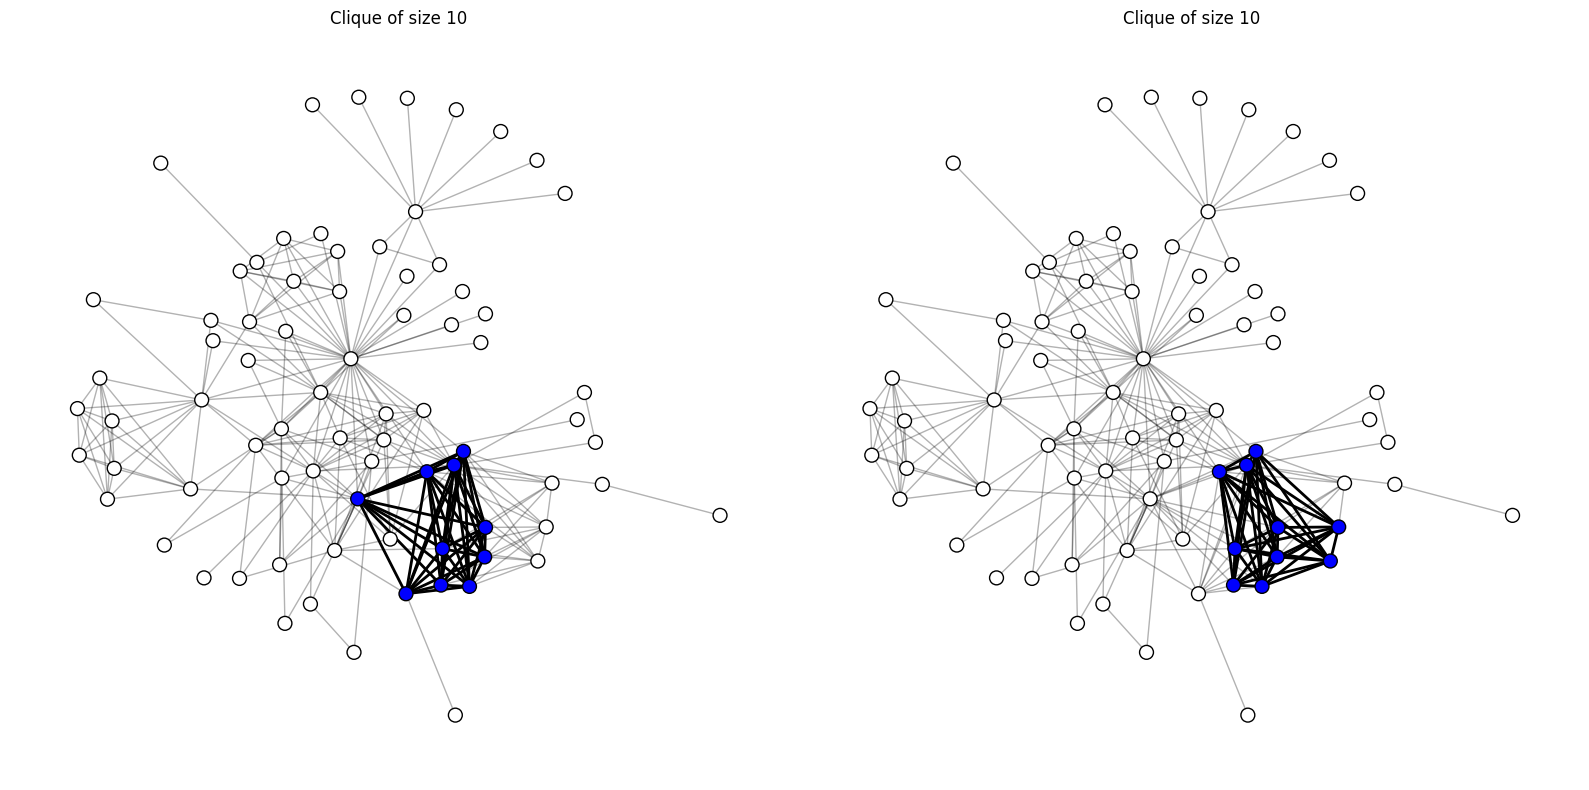

In [13]:
largest_clique_size = np.unique(colors[0], axis=0, return_counts=True)[1][0]

plt.figure(figsize=(16, 8))

for i in range(colors.shape[0]):
    max_width_edges = np.array(list(G.edges))[widths[i] == widths[i].max()]

    plt.subplot(1, 2, i + 1)

    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_color=colors[i],
        node_size=100,
        linewidths=1,
        edgecolors='black'
    )

    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )

    nx.draw_networkx_edges(
        G,
        pos,
        width=widths[i].max(),
        edgelist=max_width_edges
    )

    plt.title(f'Clique of size {largest_clique_size}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE

## Task 3. Thuật toán Girvan Newman và tính căn giữa cạnh nối (edge betweenness)

Lưu ý: Có nhiều tôi dịch thuật ngữ có thể còn thô và chưa được hay. Nếu các bạn có ý kiến đóng góp cách dịch hay hơn. Hãy cho tôi ý kiến đó. Cảm ơn các bạn.

Trong phần này, chúng ta sẽ áp dụng thuật toán Girvan Newman với tính căn giữa cạnh (edge betweenness). Ý tưởng ở đây là chúng ta cắt các cạnh với betweenness cao nhất cho đến khi nào mà đồ thị nó không còn liên thông nữa thì thôi.

Để hoàn thành phần này, các bạn sử dụng `nx.algorithms.community.girvan_newman` để tìm kiếm các cộng đồng. Các bạn viết hàm `edgeBetweeness` mà nhận đầu vào là một đồ thị và số lượng các vết cắt (divisions) `n` và trả về mảng np.array các số nguyên thể hiện nhãn của đỉnh trong mỗi vòng lặp. Shape của đầu ra là `[n, m]` trong đó `n` là số lượng vòng lặp và `m` là số lượng đỉnh.

In [14]:
def edgeBetweenness(G: nx.Graph, n: int) -> np.ndarray:
    # YOUR CODE HERE
    # Initialize the result array
    node_count = len(G.nodes())
    labels = np.zeros((n, node_count), dtype=int)

    # Create a copy of the graph to work on
    graph_copy = G.copy()

    # Iterate for n divisions
    for i, communities in enumerate(nx.algorithms.community.girvan_newman(graph_copy)):
      # Assign labels for each node based on the current division
      community_map = {node: idx for idx, community in enumerate(communities) for node in community}
      labels[i] = [community_map[node] for node in G.nodes]

      if i == n - 1:
        break

    return labels

In [15]:
# Test
labels = edgeBetweenness(G, 6)
assert labels.shape == (6, 77), "Labels array should have shape (6, 77)"
unique_labels_0 = np.unique(labels[0])
assert unique_labels_0.shape == (
    2,), "First partition should have 2 unique labels"
for i in range(1, 6):
    unique_labels_prev = np.unique(labels[i - 1])
    unique_labels_current = np.unique(labels[i])
    assert unique_labels_prev.shape[0] < unique_labels_current.shape[0], (
        f"Partition {i} should have more unique labels than partition {i-1}"
    )
assert labels[5][22] == labels[5][23], "Labels at indices 22 and 23 in partition 5 should be equal."
assert labels[5][31] == labels[5][34], "Labels at indices 31 and 34 in partition 5 should be equal."

Trực quan hóa

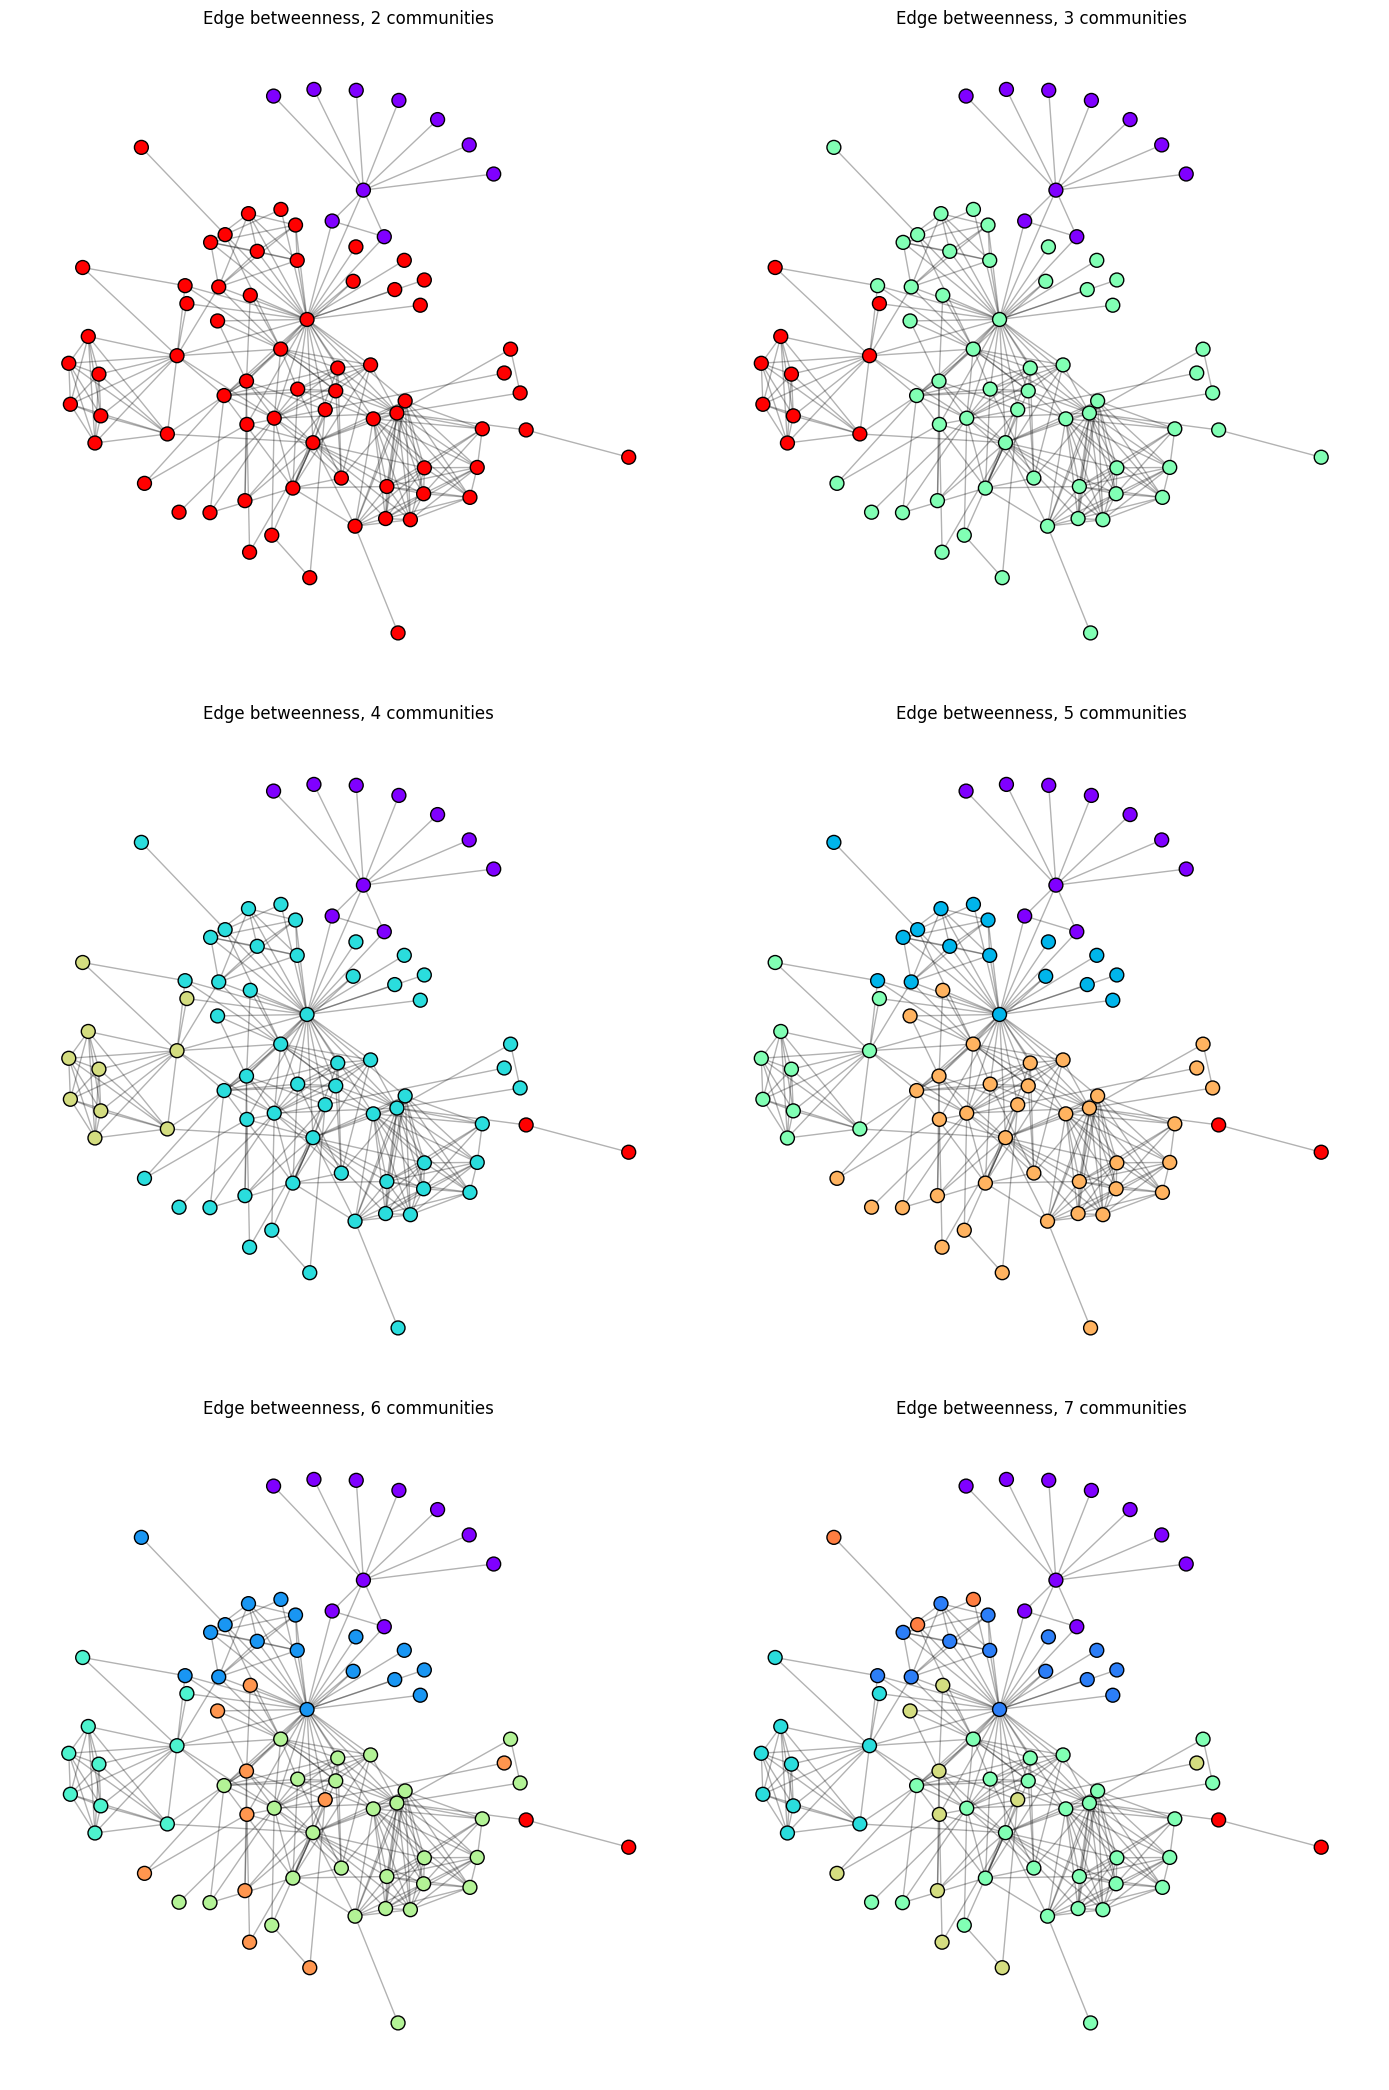

In [16]:
colors = edgeBetweenness(G, 6)

plt.figure(figsize=(14, 21))

for i in range(colors.shape[0]):
    plt.subplot(3, 2, i + 1)

    nx.draw_networkx_nodes(
        G,
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i],
        node_size=100,
        edgecolors='black'
    )

    nx.draw_networkx_edges(G, pos, alpha=0.3)

    plt.title(f'Edge betweenness, {i + 2} communities')
    plt.axis('off')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE

## Task 4. Mô-đun hóa (Modularity)

Mô-đun hóa (Modularity) giúp ta quyết định khi nào dừng phân hoạch đồ thị. Mô-đun hóa càng lớn, phân hoạch càng tốt (đọc sách Network science). Bây giờ, ta sẽ xem mô-đun hóa thay đổi như thế trong quá trình phân chia đồ thị.

Trong phần này, bạn chỉ cần hoàn thành hàm `edgeBetweennessModularity` mà nhận đầu vào là một đồ thị, số lượng bước lặp của thuật toán Girvan Newman, và trả về một mảng np.array với modularity thu được sau khi hoàn thành mỗi vòng lặp. Bạn có thể sử dụng `nx.algorithms.community.modularity`.


In [17]:
def edgeBetweennessModularity(G: nx.Graph, n: int) -> np.ndarray:
    # YOUR CODE HERE
    # Initialize an array to store modularity values
    modularity_values = np.zeros(n)

    # Create a copy of the graph to avoid modifying the original
    graph_copy = G.copy()

    # Girva-Newman generator
    communities_generator = nx.algorithms.community.girvan_newman(graph_copy)

    for i in range(n):
      # Get the current division of communities
      communities = next(communities_generator)

      # Calculate the modularity for the current division
      modularity_values[i] = nx.algorithms.community.modularity(graph_copy, communities)

    return modularity_values

In [18]:
# Test
n_iterations = 20
modularity = edgeBetweennessModularity(G, n_iterations)
assert modularity.shape == (n_iterations,), "Modularity array should have shape (20,)"
assert round(modularity[0], 4) == 0.0746, "Modularity at index 0 should be 0.0746"
assert round(modularity[7], 4) == 0.4519, "Modularity at index 7 should be 0.4519"

Trực quan hóa

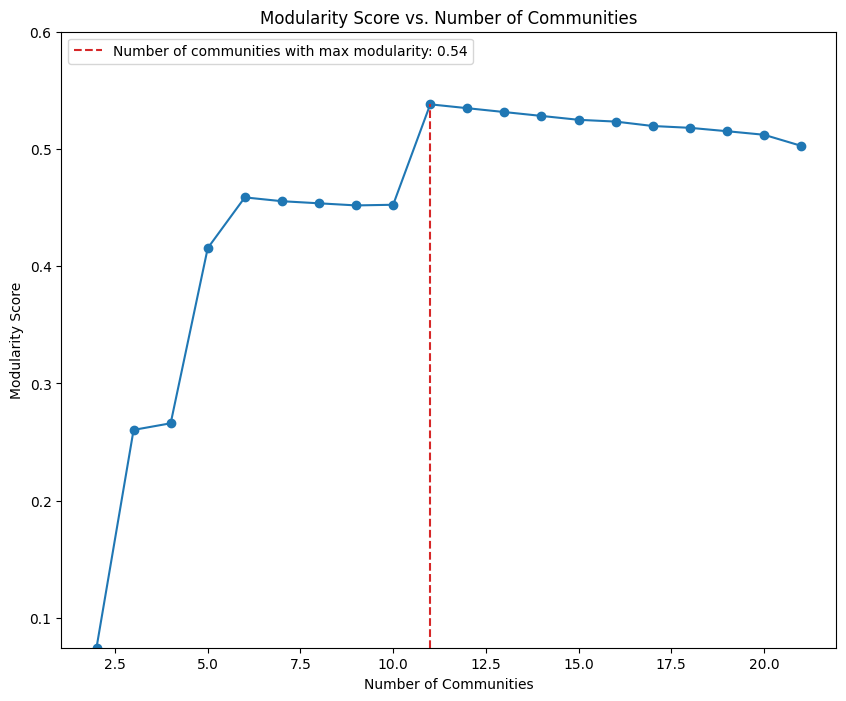

In [19]:
plt.figure(figsize=(10, 8))

plt.plot(np.arange(n_iterations) + 2, modularity, marker='o')

best_n = np.argmax(modularity) + 2
max_modularity = max(modularity)
label = f'Number of communities with max modularity: {max_modularity:.2f}'

plt.plot(
    [best_n, best_n], [min(modularity), max_modularity],
    linestyle='--', color='tab:red',
    label=label
)

plt.ylabel('Modularity Score')
plt.xlabel('Number of Communities')
plt.title('Modularity Score vs. Number of Communities')
plt.legend(loc='upper left')

plt.ylim(modularity.min(), 0.6)

plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE

## Task 5. Trị riêng (Eigenvalues) của đồ thị Laplacian

Chúng ta cần một số hàm phục vụ cho việc phát sinh đồ thị.

In [20]:
def ringLattice(n: int, k: int) -> nx.Graph:
    """Hàm tạo đồ thị vòng.

    Parameters
    ----------
    n
        (int) số lượng đỉnh cho trước
    k
        (int) bậc đỉnh

    Returns
    -------
        (nx.Graph) đồ thị kết quả
    """
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k/2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

In [21]:
def pairGraph(n):
    """Hàm tạo đồ thị đôi

    Parameters
    ----------
    n
        (int) số lượng đỉnh cho trước

    Returns
    -------
        (nx.Graph) đồ thị kết quả
    """
    G = nx.disjoint_union(nx.complete_graph(n), nx.complete_graph(n))
    G.add_edge(0, n)
    return G

In [22]:
def tripleGraph(n):
    """Hàm tạo đồ thị cặp ba

    Parameters
    ----------
    n
        (int) số lượng đỉnh cho trước

    Returns
    -------
        (nx.Graph) đồ thị kết quả
    """
    G = nx.disjoint_union_all(
        [nx.complete_graph(n), nx.complete_graph(n), nx.complete_graph(n)]
    )
    G.add_edge(0, n)
    G.add_edge(n, n*2)
    G.add_edge(n*2, 0)
    return G

Đồ thị Laplacian có công thức như sau:

$$L = D - A$$

trong đó $A$ là một ma trận kề, $D$ là ma trận đường chéo với các bậc đỉnh. Trị riêng và vector riêng của Laplacian có thể cho chúng ta biết thông tin về cấu trúc của một đồ thị. Ta sẽ xem xét một vài ví dụ đơn giản để hiểu phát biểu này.


Trong phần này, bạn hoàn thành một hàm `eigenLaplacian` mà nhận đầu vào là một đồ thị và trả về một tuple gồm hai mảng numpy array: `eigenvectors` và `eigenvalues` thể hiện cho vector riêng và trị riêng của Laplacian. Cả hai thành phần này được xếp theo thứ tự giảm dần của trị riêng.

_Gợi ý: bất kỳ ma trận đối xứng nào chỉ có trị riêng và vector riêng thực. Bạn có thể sử dụng `np.linalg.eigh` để tính toán các vector riêng và trị riêng trong một ma trận đối xứng._

In [28]:
def eigenLaplacian(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    # YOUR CODE HERE
    # Compute the Laplacian matrix
    L = nx.laplacian_matrix(G).toarray()

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = eigenvalues.argsort()
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvectors, eigenvalues

In [29]:
# Test
emptyG = nx.empty_graph(10)
vecs, vals = eigenLaplacian(emptyG)
assert vecs.sum() == 10, "Sum of eigenvectors should be 10 for empty graph"
assert vals.sum() == 0, "Sum of eigenvalues should be 0 for empty graph"

oneedgeG = nx.empty_graph(10)
oneedgeG.add_edge(0, 1)
vecs, vals = eigenLaplacian(oneedgeG)

assert abs(vecs.round(4)[0, -1]) == abs(vecs.round(4)[1, -1]) == 0.7071, (
    "Eigenvector values at indices 0 and 1 should be 0.7071"
)
assert vals[0] < vals[-1], "First eigenvalue should be less than the last eigenvalue"


completeG = nx.complete_graph(10)
vecs, vals = eigenLaplacian(completeG)
assert (vals == vals.real).sum(
) == vals.shape[0], "All eigenvalues should be real"
assert (vecs == vecs.real).sum(
) == vals.shape[0]**2, "All eigenvectors should be real"

ringG = ringLattice(10, 2)
vecs, vals = eigenLaplacian(ringG)
assert adler32(vals.round(
    4)[-1]) == 6815825, "Checksum of last eigenvalue should match"
assert adler32(vals.round(
    4)[-2]) == 393479360, "Checksum of second last eigenvalue should match"

Trực quan hóa một số đồ thị đơn giản và trị riêng Laplacian của chúng.

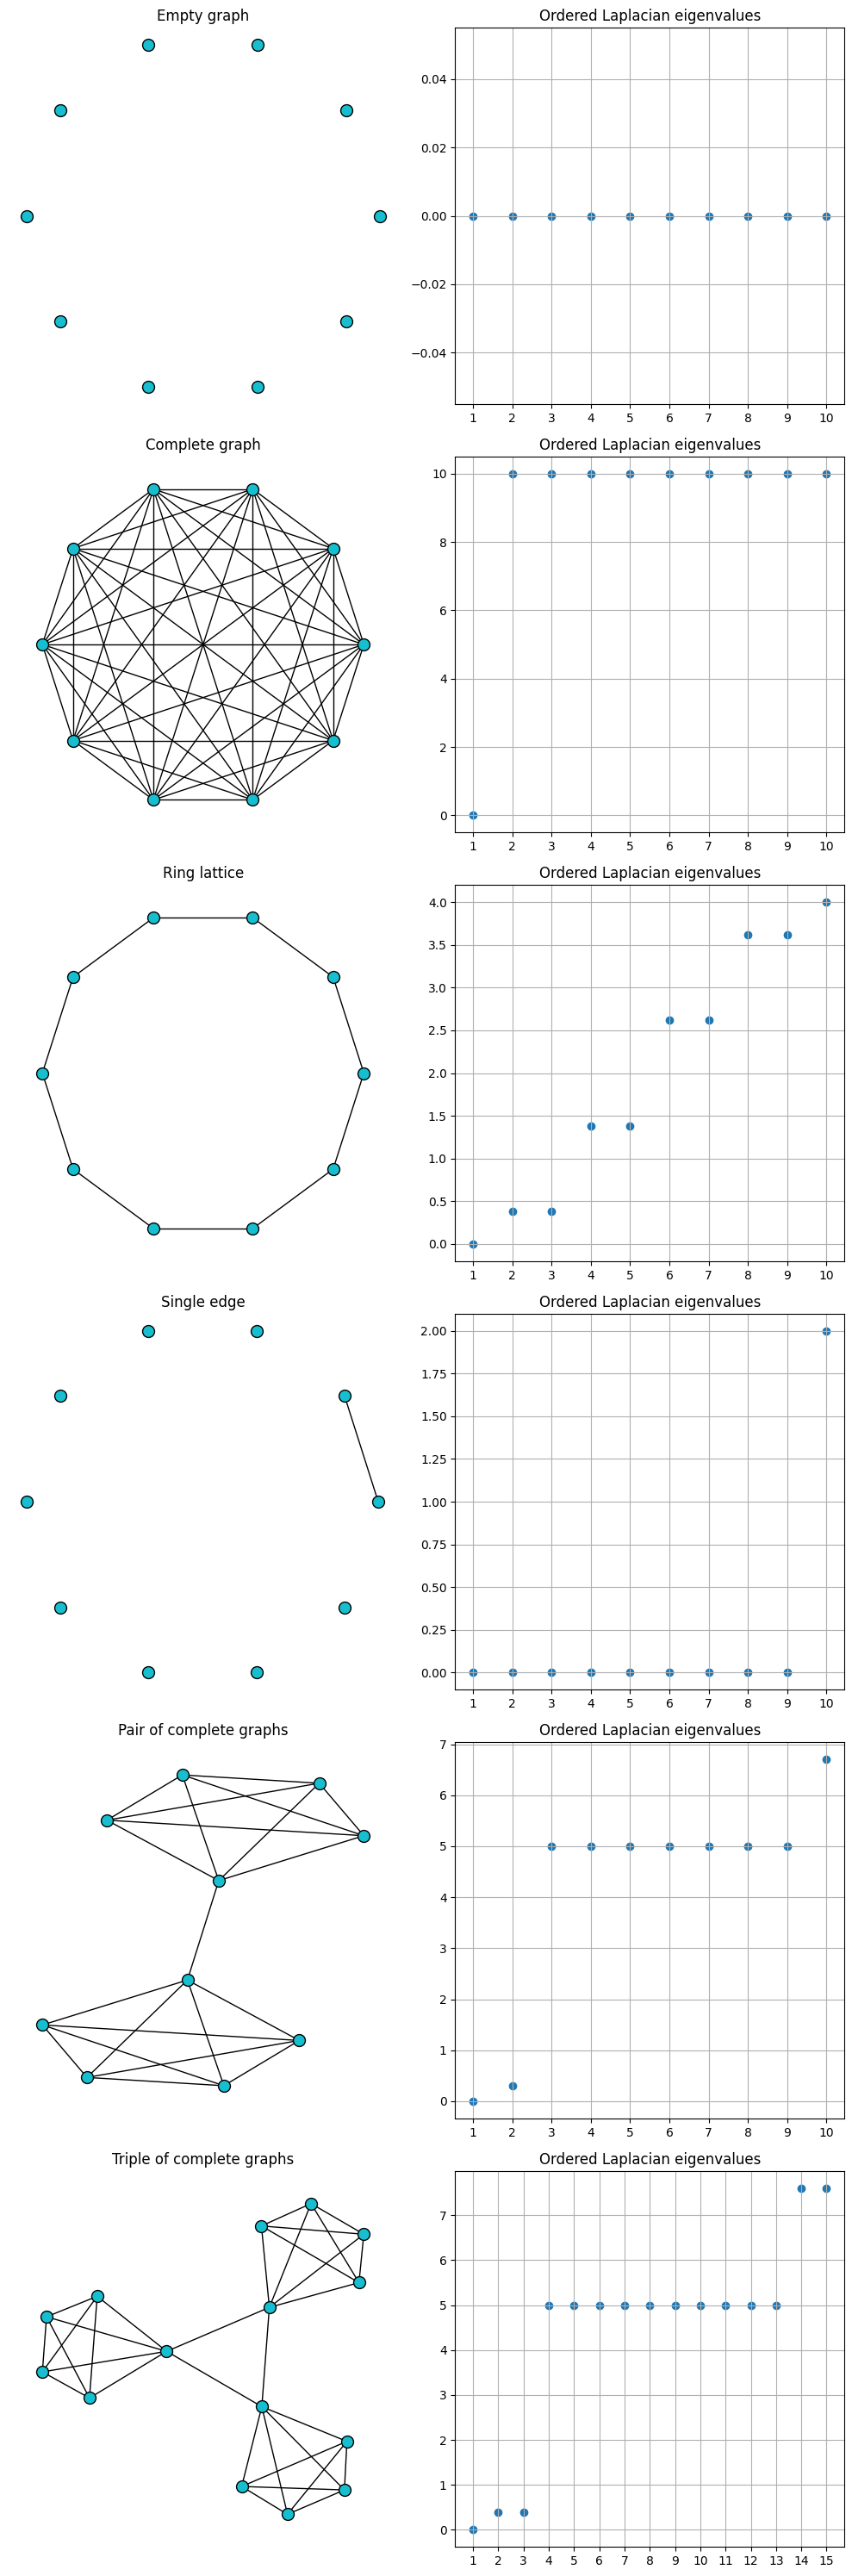

In [25]:
cases = [
    (emptyG, 'Empty graph', nx.draw_circular),
    (nx.complete_graph(10), 'Complete graph', nx.draw_circular),
    (ringLattice(10, 2), 'Ring lattice', nx.draw_circular),
    (oneedgeG, 'Single edge', nx.draw_circular),
    (pairGraph(5), 'Pair of complete graphs', nx.draw_kamada_kawai),
    (tripleGraph(5), 'Triple of complete graphs', nx.draw_kamada_kawai)
]

plt.figure(figsize=(10, 30))

for i, (graph, title, layout) in enumerate(cases, 1):
    plt.subplot(6, 2, 2*i-1)
    layout(graph, node_color='tab:cyan', edgecolors='black', node_size=100)
    plt.title(title)
    plt.axis('off')

    plt.subplot(6, 2, 2*i)
    vecs, vals = eigenLaplacian(graph)
    plt.scatter(np.arange(1, len(graph) + 1), vals)
    plt.grid(True)
    plt.xticks(np.arange(1, len(graph) + 1))
    plt.title('Ordered Laplacian eigenvalues')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

YOUR ANSWER HERE